In [3]:
import numpy as np
import torch
import sys
sys.path.append('../')
from model import Model
import matplotlib.pyplot as plt

In [4]:
model_eigenvectors = torch.jit.load("../models/eigenvectors_cosine_similarity_skip1_batch64_modelstandard_actrelu.pt")
model_simulation = torch.jit.load("../models/simulation_cosine_similarity_skip10_batch64_modelstandard_actrelu.pt")

In [5]:
input_vectors = []
output_vectors_eigenvectors = []
output_vectors_simulation = []
for i in range(3000):
    input_vector = np.loadtxt(f"../data/simulation_data/res_{i}.dat")
    input_vector = torch.tensor(input_vector).float().unsqueeze(0).unsqueeze(0).to('cuda')
    output_vectors_eigenvectors.append(model_eigenvectors(input_vector).cpu().detach().numpy().flatten())
    output_vectors_simulation.append(model_simulation(input_vector).cpu().detach().numpy().flatten())
    input_vectors.append(input_vector.cpu().detach().numpy().flatten())

In [6]:
grid_size_x = 34
grid_size_y = 34
dx = 1 / (grid_size_x)
dy = 1 / (grid_size_y)
dx2 = dx ** 2
dy2 = dy ** 2

# generate Matrix A which is the discretized Laplacian in 2D
A = np.zeros((grid_size_x * grid_size_y, grid_size_x * grid_size_y))
for i in range(grid_size_x):
    for j in range(grid_size_y):
        row = i * grid_size_y + j
        A[row, row] = -2 * (1 / dx2 + 1 / dy2)
        if i > 0:
            A[row, row - grid_size_y] = 1 / dx2
        if i < grid_size_x - 1:
            A[row, row + grid_size_y] = 1 / dx2
        if j > 0:
            A[row, row - 1] = 1 / dy2
        if j < grid_size_y - 1:
            A[row, row + 1] = 1 / dy2

A_inverse = np.linalg.inv(A)

In [7]:
X = np.vstack(input_vectors)
Y_eig = np.vstack(output_vectors_eigenvectors)
Y_sim = np.vstack(output_vectors_simulation)
Y_inv = X.dot(A_inverse)

X_pseudo_inverse = np.linalg.pinv(X)

# Calculate the matrix M
M_eig = X_pseudo_inverse.dot(Y_eig)
M_sim = X_pseudo_inverse.dot(Y_sim)

In [8]:
_, S_M_eig, _ = np.linalg.svd(M_eig)
_, S_M_sim, _ = np.linalg.svd(M_sim)
_, S_Ainv, _ = np.linalg.svd(A_inverse)

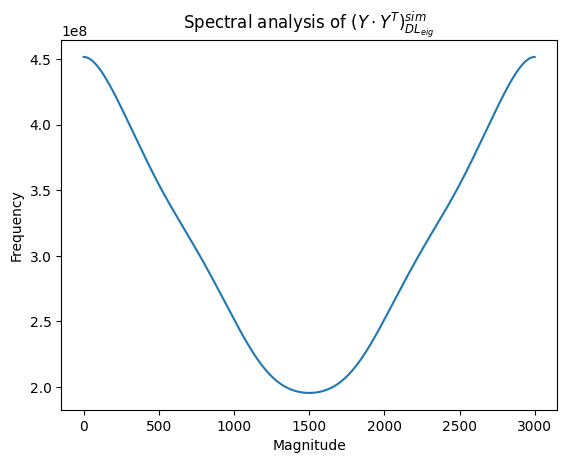

140242580.0


In [9]:
# eigenvalues of the M
eigenvalues_M_eig, eigenvectors_M_eig = np.linalg.eig(Y_eig@Y_eig.T)

# fft of eigenvalues of M
fft_eigenvalues_M_eig = np.fft.fft(eigenvalues_M_eig)

# magnitude of fft of eigenvalues of M
magnitude_fft_eigenvalues_M_eig = np.abs(fft_eigenvalues_M_eig)

plt.title("Spectral analysis of $(Y\cdot Y^T)^{sim}_{DL_{eig}}$")
plt.plot(magnitude_fft_eigenvalues_M_eig)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.savefig("eigenvectors_P_eig_sim.pdf", format="pdf")
plt.show()
print(np.max(S_M_eig))

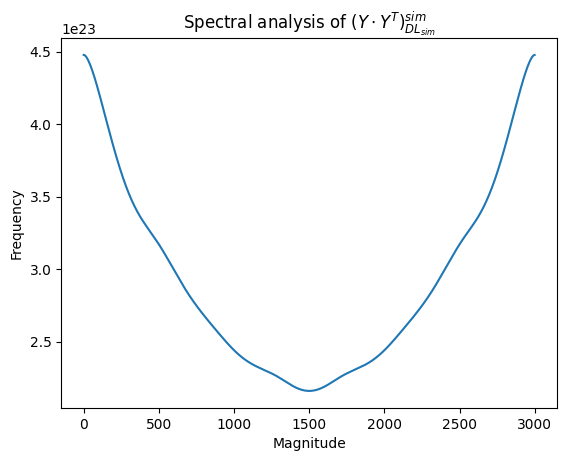

1.1669004e+16


In [10]:
# eigenvalues of the M
eigenvalues_M_sim, eigenvectors_M_sim = np.linalg.eig(Y_sim@Y_sim.T)

# fft of eigenvalues of M
fft_eigenvalues_M_sim = np.fft.fft(eigenvalues_M_sim)

# magnitude of fft of eigenvalues of M
magnitude_fft_eigenvalues_M_sim = np.abs(fft_eigenvalues_M_sim)

plt.title("Spectral analysis of $(Y\cdot Y^T)^{sim}_{DL_{sim}}$")
plt.plot(magnitude_fft_eigenvalues_M_sim)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.savefig("eigenvectors_P_sim_sim.pdf", format="pdf")
plt.show()
print(np.max(S_M_sim))

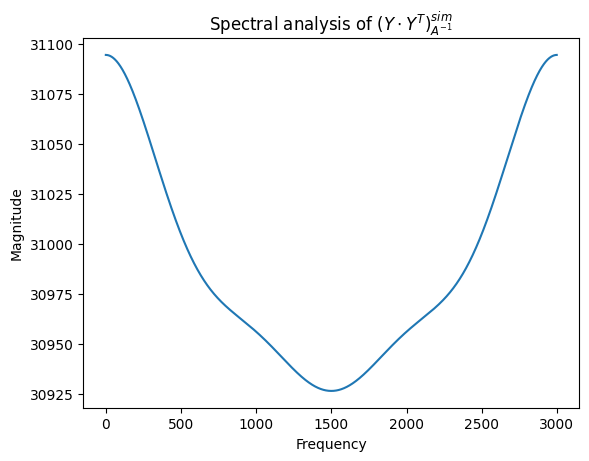

0.05372050902941864


In [11]:
# eigenvalues of the A
eigenvalues_A, eigenvectors_A = np.linalg.eig(Y_inv@Y_inv.T)

# fft of eigenvalues of A
fft_eigenvalues_A = np.fft.fft(eigenvalues_A)

# magnitude of fft of eigenvalues of A
magnitude_fft_eigenvalues_A = np.abs(fft_eigenvalues_A)

plt.title("Spectral analysis of $(Y\cdot Y^T)^{sim}_{A^{-1}}$")
plt.plot(magnitude_fft_eigenvalues_A)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.savefig("eigenvectors_A_inv_sim.pdf", format="pdf")
plt.show()
print(np.max(S_Ainv))